## Capstone Project - The Battle of Neighborhoods (Week 2)
### Applied Data Science Capstone

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Toronto, a population around over 6 million is the capital of the province of Ontario. It is a major Canadian city along Lake Ontario’s northwestern shore. It's a dynamic metropolis with a core of soaring skyscrapers, all dwarfed by the iconic, free-standing CN Tower. Toronto also has many green spaces, from the orderly oval of Queen’s Park to 400-acre High Park and its trails, sports facilities and zoo. 

According to the 2011 National Household Survey (NHS)  at https://en.wikipedia.org/wiki/Demographics_of_Toronto , there are 1,264,395 non-Whites, or 20.2% of Canada's visible minority population, live in the city of Toronto; of this, approximately 70 percent are of Asian ancestry.  

A good tasty Asian cuisines such as Nasi Lemak (Malaysia), Tom Yam(Thailand), Roti Canai(Malaysia), Lamb Korma(Indian) and many other good Asian food  are definitely among the sought after menus in the correct neighborhood.  

The questions for opening an asian restaurant would be:
1. Which area have high concentration of ethnic asian
2. Which area have less asian restaurant
3. What are common venues surrounding the neighbourhood

The problem statement for the project is 
1. Where is the best location to open an asian cuisine restaurant in Toronto

The stakeholder or the target audience for this would be 
1. Any business owner who would want to venture into food industry
2. Food chain business owner who would want to expand their businesses
3. Marketing company in food business industry
4. Fund manager who would want to fund a startup for food business
5. Food lovers themselves who just wish to have a good asian cuisines
6. Tourist who are looking for good asian cuisine 

#### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from bs4 import BeautifulSoup as bs
import lxml
print('Libraries imported.')

Libraries imported.


## Data <a name="data"></a>

We will be using data source below to answer the problem we sough to solve. Explanation of each data is inluded.

1. Data contains postal code, borough and neighborhood for Toronto area.
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M,

Description : This page will contain the table of Toronto neighborhood with postal code, borough and neighbourhood. This is very important data and where we start the project with. We will be scraping the data from the website using BeautifulSoup library and load into dataframe from manipulation

In [2]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = bs(r.text, 'html.parser')
table=soup.find('table')
len(table)
data = table.find_all('td')
len(data)
neighbourhood = [] #init list
for i,item in enumerate(data) :
    neigh = [] #init list
    span_ = item.span.text.strip()
    if not(span_ == "Not assigned"):
        text_ = item.p.text.strip()
        poscode = text_[0:3]
        try :
            borough = item.find('a').text.strip()
        except :
            borough = "NA"
        try :
            neigh = text_.split('(')[1] #remove '('
            neigh = neigh[:-1]  #remove ')' 
            #split neighbourhood by '/' and convert to list
            #neigh = neigh.split('/')
            neigh = (((neigh.replace(' /',',')).replace(')',' ')).strip(' '))
        except:
            neigh = "NA"
        #print(f"<{poscode}><{borough}><{neigh}>")
        neigh2 = {
            "PostalCode" : poscode,
            "Borough" : borough,
            "Neighborhood" :neigh,
            }
        neighbourhood.append(neigh2)
        #end if
    #end for i
df_neigh = pd.DataFrame(neighbourhood)
df_neigh['Borough']=df_neigh['Borough'].replace({'Business reply mail':'East Toronto',
                                                 'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                                 'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                                 'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                                 'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [3]:
df_neigh.shape

(103, 3)

2. Geospatial information for Toronto borough and neighborhood

https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

Description : This data will provide the latitude and longitude information for the neighborhood in Toronto. We will read them from the source (csv format)  and load to dataframe and then match them to the Toronto neighborhood data we have above.

In [4]:
df_latlong = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv")
df_latlong.head()
df_latlong.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
df_neigh.head(5)
# merge Lat Long and create Toronto Neighbourhood dataframe
Toronto_data = df_neigh.join(df_latlong.set_index('PostalCode'), on='PostalCode')
Toronto_data.head()
Toronto_data.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509
102,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999


In [5]:
Toronto_data.shape

(103, 5)

#### new Toronto_data having information of neighborhoood and its latitude and longitude above

3. Demography breakdown of Toronto area based on the ethnic

Demographics of Toronto – Wikipedia at https://en.wikipedia.org/wiki/Demographics_of_Toronto. Data has been extracted and saved in CSV file in C:/Users/USER/DataScience/Capstone/TorontoDemographic.csv

Description : This data will provide concentration of ethnic in Toronto areas. We can then zoom into these areas where asian ethnic are high in density. 

In [6]:
df_demographic = pd.read_csv("C:/Users/USER/DataScience/Capstone/TorontoDemographic.csv")
for i in range(len(df_demographic)) :
    df_demographic['Borough'][i] = df_demographic['Borough'][i].split('(')[0]
df_demographic

,Borough,Race1,Race2,Race3,Race4,Race5,Race6
0,"Toronto,East York",White: 65.3%,Chinese: 8.9%,South Asian: 6.7%,Black: 5.6%,NaN,NaN
1,North York,White: 47.4%,Chinese: 14.0%,South Asian: 8.5%,Black: 5.2%,Filipino: 8.0%,West Asian: 5.3%
2,Scarborough,White: 26.5%,Chinese: 19.0%,South Asian: 25.4%,Black: 10.8%,Filipino: 8.4%,NaN
3,"Etobicoke,York",White: 48.9%,Black: 15.7%,South Asian: 11.9%,", Latin American: 5.6%",NaN,NaN


In [7]:
df_demographic['Borough']

0    Toronto,East York
1           North York
2          Scarborough
3       Etobicoke,York
Name: Borough, dtype: object

#### Based from the population breakdown above, these are the 7 borroughs having high density of asian ethnic in Toronto area, hence we will be focusing on these areas

4. Foursquare location data via API for identifying and exploring the selected localities and surroundings areas where high in ethnic asian population

Creation of developer account is required to have an access to Foursquare API.

Foursquare API can be accessed as below

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

Credentials and parameters must be supplied for each of the request such as

1. CLIENT_ID = 'xxx' # your Foursquare ID

2. CLIENT_SECRET = 'xxx' # your Foursquare Secret

3. ACCESS_TOKEN = 'xxx' # your FourSquare Access Token

4. VERSION = '20180604'

Foursquare location data will be critical in exploring the localities and find the concentration of asian food outlet or restaurant in those searched areas.

Hence, we would leverage Foursquare location data to:
    
    1. identify the location of most dense Asian origin population in Toronto
    
    2. identify the top 10 most common venues for neighborhood with dense Asian origin
    
    3. Less dense Asian restaurant in the dense Asian origin area

## Methodology <a name="methodology"></a>

#### Explain methodology of how to do this

1. use the concentrated ethic asian area as per wikipedia demographic information as top asian neighbourhood. Based from the data, there are about 7 buroughs identified as having the most density of asian ethinic. We locate all neighbourhood under these 7 buroghs and put them in dataframe. This will be the source of our analysis areas. 
2. locate and analyze the nearby asian restaurant within 500m and put them in the dataframe
3. Once we have the list
4. if possible differentiate them in color 
5. Now let's create the new dataframe and display the top 10 venues for each top asian neighborhood .
6. K means clustering for top 5 asian neighbourhood 

manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Let's print each neighborhood along with the top 5 most common venues
Let's put that into a pandas dataframe


Get the neighborhood from Borough with high Asian ethnic 

In [9]:
combine_borough = df_demographic.Borough.values
pattern = '|'.join(combine_borough)
pattern = pattern.replace(",","|") 
print("These are Burroghs with high ethnic Asian density in Toronto")
pattern

These are Burroghs with high ethnic Asian density in Toronto


'Toronto|East York|North York|Scarborough|Etobicoke|York'

In [10]:
rows_tokeep = Toronto_data[Toronto_data['Borough'].str.contains(pattern, case=False)].index
good_df = Toronto_data.index.isin(rows_tokeep)
bad_index = Toronto_data[~good_df].index
#to delete rows with Burroghs not in dense Asian ethnic areas
Toronto_data.drop(bad_index, inplace=True)
# reset index after dropping rows
Toronto_data.reset_index(drop=True, inplace=True)

In [11]:
Toronto_data.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
78,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
79,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
80,M7Y,East Toronto,Enclave of M4L,43.662744,-79.321558
81,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509
82,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999


In [12]:
print("Now we have only {} Neighborhood in Toronto area to work with".format(Toronto_data.shape[0]))

Now we have only 83 Neighborhood in Toronto area to work with


#### 1. Locating Toronto latitude and visualize Toronto Neighborhood using geopy.Nominatim
##### Then, map Toronto Neighborhood  with most Asian ethnic

In [13]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:
#Toronto_data = df_Toronto
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

Explore  localities in one of the areas.
concentrate on the areas where asian ethnic are high density

In [15]:
area_no = 74 #pick random Neighborhood
neighborhood_name = Toronto_data.loc[area_no,'Neighborhood']
neighborhood_latitude = Toronto_data.loc[area_no,'Latitude']
neighborhood_longitude = Toronto_data.loc[area_no,'Longitude']
neighborhood_bor = Toronto_data.loc[area_no,'Borough']
print('Latitude and longitude values of {}, Borough {} are {}, {}.'.format(neighborhood_name,
                                                                           neighborhood_bor,
                                                                           neighborhood_latitude, 
                                                                           neighborhood_longitude))

Latitude and longitude values of Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale, Borough Etobicoke are 43.7067483, -79.5940544.


In [16]:
# type your answer here
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61033b3ede29ac5bfe077cf2'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.7112483045, 'lng': -79.58784096674265},
   'sw': {'lat': 43.7022482955, 'lng': -79.60026783325736}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5273f6f311d2137549494e29',
       'name': 'Economy Rent A Car',
       'location': {'lat': 43.708471,
        'lng': -79.589943,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.708471,
          'lng': -79.589943}],
        'distance': 382,
        'cc': 'CA',
        'country': 'Canada',
        'formattedAddress': ['Canada']},
       'categories': [{'id': '4bf58dd8d

In [18]:
#should be ok when u get the result from the right query
'There are {} popular spots around {} in {} burough'.format(len(results['response']['groups'][0]['items']),neighborhood_name, neighborhood_bor)

'There are 5 popular spots around Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale in Etobicoke burough'

#### 2. Function to get popular venue in the neighbourhood

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    #will put all venue in venue_list into dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

create Toronto venues dataframe

In [20]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Islington Avenue
Malvern, Rouge
Don Mills Nort
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills Sout
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
Toronto Dominion Centre, Design Exchange
Golden Mile, Clairlea, Oakridge
York Mills, Silver Hills
Downsview We

In [21]:
Toronto_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1746,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Jim & Maria's No Frills,43.631152,-79.518617,Grocery Store
1747,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
1748,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store
1749,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym
1750,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Burrito Boyz,43.626657,-79.526349,Burrito Place


Let's check how many venues were returned for each neighborhood

In [22]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Caledonia-Fairbanks,4,4,4,4,4,4


## Analysis <a name="analysis"></a>

## 1. Search for a venue category with Asian restaurant

> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

In [24]:
search_query = 'Asian'
radius = 500
print(search_query + ' .... OK!')

Asian .... OK!


Explore neighbourhood with Asian restaurant

In [76]:
#ORI>url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, ACCESS_TOKEN, VERSION, search_query, LIMIT)


In [26]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61033c5e1f6a821709863762'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4baa41f4f964a5204d583ae3',
    'name': "Asian Wok 'n' Roll",
    'location': {'address': '2919 Derry Rd. E',
     'crossStreet': 'at Airport Rd.',
     'lat': 43.70332601609809,
     'lng': -79.64307407376991,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.70332601609809,
       'lng': -79.64307407376991}],
     'distance': 3963,
     'postalCode': 'L4T 1A6',
     'cc': 'CA',
     'city': 'Mississauga',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['2919 Derry Rd. E (at Airport Rd.)',
      'Mississauga ON L4T 1A6',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d145941735',
      'name': 'Chinese Restaurant',
      'pluralName': 'Chinese Restaurants',
      'shortName': 'Chinese',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
 

In [27]:
'There are {} popular spots around {}.'.format(len(results['response']['venues']),neighborhood_name)

'There are 50 popular spots around Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale.'

In [28]:
Toronto_data.loc[area_no,'Borough']

'Etobicoke'

### Get Asian restaurant and create dataframe

In [29]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-29-5acf500bf9ad>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4baa41f4f964a5204d583ae3,Asian Wok 'n' Roll,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1627602014,False,2919 Derry Rd. E,at Airport Rd.,43.703326,-79.643074,"[{'label': 'display', 'lat': 43.70332601609809...",3963,L4T 1A6,CA,Mississauga,ON,Canada,"[2919 Derry Rd. E (at Airport Rd.), Mississaug..."
1,4ca8be1a14c337042a15d73b,Asian Food Centre,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1627602014,False,308 Eddystone Ave,NaN,43.747486,-79.523262,"[{'label': 'display', 'lat': 43.7474858, 'lng'...",7279,M3N 1H7,CA,Toronto,ON,Canada,"[308 Eddystone Ave, Toronto ON M3N 1H7, Canada]"
2,4bd88db4f645c9b6ea3da8e0,Asian Food Centre,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1627602014,False,80 Pertosa Dr,NaN,43.676957,-79.794021,"[{'label': 'display', 'lat': 43.67695709409592...",16433,L6X 5E9,CA,Brampton,ON,Canada,"[80 Pertosa Dr, Brampton ON L6X 5E9, Canada]"
3,4b9d791df964a52013af36e3,Asian Buffet,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1627602014,False,161 Rexdale Blvd.,NaN,43.711009,-79.568666,"[{'label': 'display', 'lat': 43.71100888025233...",2097,NaN,CA,Etobicoke,ON,Canada,"[161 Rexdale Blvd., Etobicoke ON, Canada]"
4,4c155ecf7f7f2d7fe568e268,Asian Food Centre,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1627602014,False,Ceremonial Dr,NaN,43.606771,-79.677599,"[{'label': 'display', 'lat': 43.60677069982758...",13005,NaN,CA,Mississauga,ON,Canada,"[Ceremonial Dr, Mississauga ON, Canada]"


In [30]:
dataframe.shape

(50, 17)

In [33]:
#will search for Asian restaurant nearby neighborhood
search_query = 'Asian'
radius = 1000  # set to 1000m
LIMIT = 100 # set to 100 venues
print(search_query + ' .... OK!')
for i in range(len(Toronto_data)):
    url_x = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Toronto_data.loc[i,'Latitude'], Toronto_data.loc[i,'Longitude'], ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    results_x = requests.get(url_x).json()
    try:
        num_venues = len(results_x['response']['venues']) #get number of venues
    except:
        num_venues = 0
    print("<>",i,"<>",num_venues,"<>",Toronto_data.loc[i,'Latitude'],"<>",Toronto_data.loc[i,'Longitude'])
    Toronto_data.loc[i,'AsianRestaurant'] = num_venues
    print('There are {} popular spots around {} in {}.'.format(num_venues,Toronto_data.loc[i,'Neighborhood'],Toronto_data.loc[i,'Borough']))
#dataframe2 = json_normalize(results_x['response']['venues'])

Asian .... OK!
<> 0 <> 0 <> 43.7532586 <> -79.3296565
There are 0 popular spots around Parkwoods in North York.
<> 1 <> 0 <> 43.7258823 <> -79.3155716
There are 0 popular spots around Victoria Village in North York.
<> 2 <> 0 <> 43.6542599 <> -79.3606359
There are 0 popular spots around Regent Park, Harbourfront in Downtown Toronto.
<> 3 <> 0 <> 43.718518 <> -79.4647633
There are 0 popular spots around Lawrence Manor, Lawrence Heights in North York.
<> 4 <> 0 <> 43.6678556 <> -79.5322424
There are 0 popular spots around Islington Avenue in Etobicoke.
<> 5 <> 0 <> 43.8066863 <> -79.1943534
There are 0 popular spots around Malvern, Rouge in Scarborough.
<> 6 <> 0 <> 43.7459058 <> -79.352188
There are 0 popular spots around Don Mills Nort in North York.
<> 7 <> 0 <> 43.7063972 <> -79.309937
There are 0 popular spots around Parkview Hill, Woodbine Gardens in East York.
<> 8 <> 9 <> 43.6571618 <> -79.3789371
There are 9 popular spots around Garden District, Ryerson in Downtown Toronto.
<> 9

<> 70 <> 0 <> 43.7995252 <> -79.3183887
There are 0 popular spots around Steeles West, L'Amoreaux West in Scarborough.
<> 71 <> 0 <> 43.6795626 <> -79.3775294
There are 0 popular spots around Rosedale in Downtown Toronto.
<> 72 <> 6 <> 43.6464352 <> -79.374846
There are 6 popular spots around Enclave of M5E in Downtown Toronto.
<> 73 <> 0 <> 43.6024137 <> -79.5434841
There are 0 popular spots around Alderwood, Long Branch in Etobicoke.
<> 74 <> 0 <> 43.7067483 <> -79.5940544
There are 0 popular spots around Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale in Etobicoke.
<> 75 <> 0 <> 43.8361247 <> -79.2056361
There are 0 popular spots around Upper Rouge in Scarborough.
<> 76 <> 1 <> 43.667967 <> -79.3676753
There are 1 popular spots around St. James Town, Cabbagetown in Downtown Toronto.
<> 77 <> 10 <> 43.6484292 <> -79.3822802
There are 10 popular spots around First Canadian Place, Underground city in Downtown Toronto.
<> 78 <>

In [34]:
Toronto_data.shape

(83, 6)

In [35]:
Toronto_data.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,AsianRestaurant
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0
4,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0.0


### get the list of Asian restaurant in Asian ethnic populated neighborhood.
Downtown Toronto having the most restaurant in which Central Bay Street being the most number of Asian restaurant.

In [36]:
#final_df = df.sort_values(by=['2'], ascending=False)
Toronto_data.sort_values('AsianRestaurant',ascending=False).head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,AsianRestaurant
22,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,12.0
77,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,10.0
28,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,10.0
37,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,9.0
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,9.0
41,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,8.0
65,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,8.0
79,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,7.0
14,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,7.0
72,M5W,Downtown Toronto,Enclave of M5E,43.646435,-79.374846,6.0


In [37]:
Toronto_data.shape

(83, 6)

In [38]:
T_data = Toronto_data[['Borough','Neighborhood',]].groupby('Borough').count()
T_data.sort_values(['Neighborhood'], ascending=False, axis=0, inplace=True)
T_data

,Neighborhood
Borough,
North York,24
Downtown Toronto,18
Scarborough,17
Etobicoke,12
East York,5
York,5
East Toronto,1
North Toronto,1


In [39]:
Toronto_data.groupby('Borough').count()

,PostalCode,Neighborhood,Latitude,Longitude,AsianRestaurant
Borough,,,,,
Downtown Toronto,18,18,18,18,18
East Toronto,1,1,1,1,1
East York,5,5,5,5,5
Etobicoke,12,12,12,12,12
North Toronto,1,1,1,1,1
North York,24,24,24,24,24
Scarborough,17,17,17,17,17
York,5,5,5,5,5


In [40]:
Toronto_data.groupby('Borough').sum()

,Latitude,Longitude,AsianRestaurant
Borough,,,
Downtown Toronto,785.775045,-1428.905966,101.0
East Toronto,43.662744,-79.321558,0.0
East York,218.501517,-396.679256,0.0
Etobicoke,523.920516,-954.504883,2.0
North Toronto,43.715383,-79.405678,2.0
North York,1050.017458,-1906.304120,7.0
Scarborough,744.025891,-1347.234449,10.0
York,218.453984,-397.363167,6.0


In [41]:
df_t = Toronto_data[['Borough','AsianRestaurant']].groupby('Borough').count()

In [42]:
df_t.sort_values(['AsianRestaurant'], ascending=False, axis=0, inplace=True)

In [43]:
df_tt = df_t.transpose()

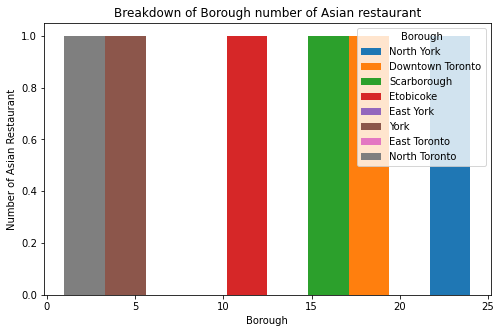

In [44]:
import matplotlib.pyplot as plt
df_tt.plot(kind='hist', figsize=(8, 5))
plt.title('Breakdown of Borough number of Asian restaurant')
plt.ylabel('Number of Asian Restaurant')
plt.xlabel('Borough')
plt.show()

Text(0.5, 1.0, 'Borough with Asian Restaurant')

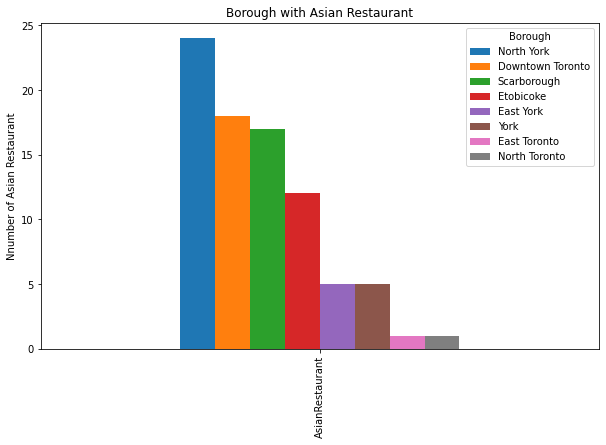

In [184]:
df_tt.plot(kind='bar', figsize=(10, 6))  # rotate the xticks(labelled points on x-axis) by 90 degrees
#, rot=90
#plt.xlabel('Year')
plt.ylabel('Nnumber of Asian Restaurant')
plt.title('Borough with Asian Restaurant')

### Let visualize the most Asian restaurant neighborhood !

In [45]:
#create Toronto_Asian dataframe
Toronto_Asian = Toronto_data.sort_values('AsianRestaurant',ascending=False)

In [46]:
#Toronto_data = df_Toronto
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, restaurant in zip(Toronto_Asian['Latitude'], Toronto_Asian['Longitude'], Toronto_Asian['Neighborhood'], Toronto_Asian['AsianRestaurant']):
    label = folium.Popup(label+"("+str(restaurant)+")", parse_html=True)
    if restaurant > 5 :
        color_ = 'green'
    elif (restaurant > 0) & (restaurant < 6) :
        color_ = 'blue'
    else :
        color_ = 'red'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color_,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### !!Looking at the map above, neighbourhood with > 5 Asian restaurant within 1km radius will be colored in green.. blue is between 1 to 5 and red is 0... we can conclude that most of asian restaurant located in the nearby vicinity Downtown Toronto

#### hence, any location outside Downtown Toronto is good place to setup Asian restaurant!

In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    #will put all venue in venue_list into dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [48]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Islington Avenue
Malvern, Rouge
Don Mills Nort
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills Sout
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
Toronto Dominion Centre, Design Exchange
Golden Mile, Clairlea, Oakridge
York Mills, Silver Hills
Downsview We

In [49]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Caledonia-Fairbanks,4,4,4,4,4,4


In [50]:
Toronto_venues.shape

(1751, 7)

### 3. Analyze Each Neighborhood

In [51]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']])

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Field,Venue Category_Baseball Stadium,Venue Category_Basketball Court,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bike Shop,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bridal Shop,Venue Category_Bubble Tea Shop,Venue Category_Building,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Butcher,Venue Category_Café,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_College Stadium,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Creperie,Venue Category_Cupcake Shop,Venue Category_Curling Ice,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Field,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Service,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Golf Course,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Hakka Restaurant,Venue Category_Harbor / Marina,Venue Category_Hardware Store,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Hobby Shop,Venue Category_Hockey Arena,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospita

In [52]:
Toronto_onehot.shape

(1751, 257)

In [53]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Field,Venue Category_Baseball Stadium,Venue Category_Basketball Court,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bike Shop,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bridal Shop,Venue Category_Bubble Tea Shop,Venue Category_Building,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Butcher,Venue Category_Café,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_College Stadium,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Creperie,Venue Category_Cupcake Shop,Venue Category_Curling Ice,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Field,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Service,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Golf Course,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Hakka Restaurant,Venue Category_Harbor / Marina,Venue Category_Hardware Store,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Hobby Shop,Venue Category_Hockey Arena,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospita

In [54]:
Toronto_grouped.shape

(80, 257)

#### Let's print each neighborhood along with the top 5 most common venues

In [55]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                                      venue  freq
0                     Venue Category_Lounge  0.25
1             Venue Category_Breakfast Spot  0.25
2  Venue Category_Latin American Restaurant  0.25
3             Venue Category_Clothing Store  0.25
4          Venue Category_Accessories Store  0.00


----Alderwood, Long Branch----
                           venue  freq
0     Venue Category_Pizza Place  0.33
1             Venue Category_Gym  0.17
2  Venue Category_Sandwich Place  0.17
3             Venue Category_Pub  0.17
4     Venue Category_Coffee Shop  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
                                      venue  freq
0                Venue Category_Coffee Shop  0.10
1                       Venue Category_Bank  0.10
2                       Venue Category_Park  0.05
3              Venue Category_Shopping Mall  0.05
4  Venue Category_Middle Eastern Restaurant  0.05


----Bayview Village----
                               

                                 venue  freq
0        Venue Category_Clothing Store  0.09
1           Venue Category_Coffee Shop  0.08
2  Venue Category_Fast Food Restaurant  0.06
3            Venue Category_Restaurant  0.05
4                Venue Category_Bakery  0.03


----First Canadian Place, Underground city----
                        venue  freq
0  Venue Category_Coffee Shop  0.09
1         Venue Category_Café  0.07
2        Venue Category_Hotel  0.06
3          Venue Category_Gym  0.04
4   Venue Category_Restaurant  0.04


----Garden District, Ryerson----
                                venue  freq
0          Venue Category_Coffee Shop  0.10
1       Venue Category_Clothing Store  0.09
2      Venue Category_Bubble Tea Shop  0.03
3  Venue Category_Japanese Restaurant  0.03
4                Venue Category_Hotel  0.03


----Glencairn----
                                venue  freq
0          Venue Category_Pizza Place   0.2
1     Venue Category_Sushi Restaurant   0.2
2             

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Venue Category_Lounge,Venue Category_Breakfast Spot,Venue Category_Latin American Restaurant,Venue Category_Clothing Store,Venue Category_Accessories Store,Venue Category_Miscellaneous Shop,Venue Category_Monument / Landmark,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Modern European Restaurant,Venue Category_Mobile Phone Shop
1,"Alderwood, Long Branch",Venue Category_Pizza Place,Venue Category_Gym,Venue Category_Sandwich Place,Venue Category_Pub,Venue Category_Coffee Shop,Venue Category_Metro Station,Venue Category_Men's Store,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Motel
2,"Bathurst Manor, Wilson Heights, Downsview North",Venue Category_Coffee Shop,Venue Category_Bank,Venue Category_Park,Venue Category_Shopping Mall,Venue Category_Middle Eastern Restaurant,Venue Category_Mobile Phone Shop,Venue Category_Sandwich Place,Venue Category_Fried Chicken Joint,Venue Category_Supermarket,Venue Category_Sushi Restaurant
3,Bayview Village,Venue Category_Japanese Restaurant,Venue Category_Chinese Restaurant,Venue Category_Bank,Venue Category_Café,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Movie Theater,Venue Category_Modern European Restaurant
4,"Bedford Park, Lawrence Manor East",Venue Category_Italian Restaurant,Venue Category_Sushi Restaurant,Venue Category_Coffee Shop,Venue Category_Pizza Place,Venue Category_Sandwich Place,Venue Category_Hobby Shop,Venue Category_Greek Restaurant,Venue Category_Juice Bar,Venue Category_Pub,Venue Category_Liquor Store


#### 4. Cluster Neighborhoods

In [58]:
neighborhoods_venues_sorted['1st Most Common Venue'].unique()

array(['Venue Category_Lounge', 'Venue Category_Pizza Place',
       'Venue Category_Coffee Shop', 'Venue Category_Japanese Restaurant',
       'Venue Category_Italian Restaurant', 'Venue Category_Café',
       'Venue Category_Airport Lounge', 'Venue Category_Park',
       'Venue Category_Bank', 'Venue Category_Grocery Store',
       'Venue Category_Garden Center', 'Venue Category_Motel',
       'Venue Category_Sandwich Place', 'Venue Category_Restaurant',
       'Venue Category_Indian Restaurant', 'Venue Category_Food Truck',
       'Venue Category_Airport', 'Venue Category_Discount Store',
       'Venue Category_Yoga Studio', 'Venue Category_Clothing Store',
       'Venue Category_Bakery', 'Venue Category_Medical Center',
       'Venue Category_Fast Food Restaurant',
       'Venue Category_Food Service', 'Venue Category_Field',
       'Venue Category_Department Store', 'Venue Category_Intersection',
       'Venue Category_Pharmacy',
       'Venue Category_Construction & Landscaping',

In [59]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [60]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_data

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.tail() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,AsianRestaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0.0,3.0,Venue Category_River,Venue Category_Pool,Venue Category_Accessories Store,Venue Category_Middle Eastern Restaurant,Venue Category_Monument / Landmark,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Modern European Restaurant,Venue Category_Mobile Phone Shop,Venue Category_Miscellaneous Shop,Venue Category_Mexican Restaurant
79,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,7.0,3.0,Venue Category_Coffee Shop,Venue Category_Japanese Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Gay Bar,Venue Category_Fast Food Restaurant,Venue Category_Hotel,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Pub
80,M7Y,East Toronto,Enclave of M4L,43.662744,-79.321558,0.0,3.0,Venue Category_Yoga Studio,Venue Category_Auto Workshop,Venue Category_Smoke Shop,Venue Category_Park,Venue Category_Spa,Venue Category_Burrito Place,Venue Category_Fast Food Restaurant,Venue Category_Farmers Market,Venue Category_Light Rail Station,Venue Category_Garden
81,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0.0,3.0,Venue Category_Breakfast Spot,Venue Category_Baseball Field,Venue Category_Accessories Store,Venue Category_Moroccan Restaurant,Venue Category_Massage Studio,Venue Category_Medical Center,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant
82,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,0.0,3.0,Venue Category_Grocery Store,Venue Category_Fast Food Restaurant,Venue Category_Bakery,Venue Category_Tanning Salon,Venue Category_Sandwich Place,Venue Category_Discount Store,Venue Category_Supplement Shop,Venue Category_Gym,Venue Category_Kids Store,Venue Category_Burrito Place


Finally, let's visualize the resulting clusters

In [61]:
Toronto_merged['Cluster Labels'].unique()

array([ 1.,  3., nan,  0.,  2.,  4.])

#### There are neighborhood with Nan value, so we delete them

In [62]:
# simply drop whole row with NaN in "Most Common Venue" column
Toronto_merged.dropna(subset=["1st Most Common Venue"], axis=0, inplace=True)

# reset index, because we droped two rows
Toronto_merged.reset_index(drop=True, inplace=True)

In [63]:
Toronto_merged['Cluster Labels'].unique()

array([1., 3., 0., 2., 4.])

In [64]:
#change the Cluster Labels to int type for map visualization
Toronto_merged['Cluster Labels'] = Toronto_merged['Cluster Labels'].astype(int)

## Result <a name="result"></a>

In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [67]:
Toronto_grouped.shape

(80, 257)

In [68]:
Toronto_grouped.head(5)

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Field,Venue Category_Baseball Stadium,Venue Category_Basketball Court,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bike Shop,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bridal Shop,Venue Category_Bubble Tea Shop,Venue Category_Building,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Butcher,Venue Category_Café,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_College Stadium,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Creperie,Venue Category_Cupcake Shop,Venue Category_Curling Ice,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Field,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Service,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Golf Course,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Hakka Restaurant,Venue Category_Harbor / Marina,Venue Category_Hardware Store,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Hobby Shop,Venue Category_Hockey Arena,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospita

In [69]:
Toronto_merged.tail() #Common Venue

,PostalCode,Borough,Neighborhood,Latitude,Longitude,AsianRestaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0.0,3,Venue Category_River,Venue Category_Pool,Venue Category_Accessories Store,Venue Category_Middle Eastern Restaurant,Venue Category_Monument / Landmark,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Modern European Restaurant,Venue Category_Mobile Phone Shop,Venue Category_Miscellaneous Shop,Venue Category_Mexican Restaurant
76,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,7.0,3,Venue Category_Coffee Shop,Venue Category_Japanese Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Gay Bar,Venue Category_Fast Food Restaurant,Venue Category_Hotel,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Pub
77,M7Y,East Toronto,Enclave of M4L,43.662744,-79.321558,0.0,3,Venue Category_Yoga Studio,Venue Category_Auto Workshop,Venue Category_Smoke Shop,Venue Category_Park,Venue Category_Spa,Venue Category_Burrito Place,Venue Category_Fast Food Restaurant,Venue Category_Farmers Market,Venue Category_Light Rail Station,Venue Category_Garden
78,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0.0,3,Venue Category_Breakfast Spot,Venue Category_Baseball Field,Venue Category_Accessories Store,Venue Category_Moroccan Restaurant,Venue Category_Massage Studio,Venue Category_Medical Center,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant
79,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,0.0,3,Venue Category_Grocery Store,Venue Category_Fast Food Restaurant,Venue Category_Bakery,Venue Category_Tanning Salon,Venue Category_Sandwich Place,Venue Category_Discount Store,Venue Category_Supplement Shop,Venue Category_Gym,Venue Category_Kids Store,Venue Category_Burrito Place


In [70]:
Toronto_merged.sort_values('AsianRestaurant',ascending=False).head(30)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,AsianRestaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,12.0,3,Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Italian Restaurant,Venue Category_Sandwich Place,Venue Category_Restaurant,Venue Category_Spa,Venue Category_Bubble Tea Shop,Venue Category_Burger Joint,Venue Category_Japanese Restaurant,Venue Category_Salad Place
26,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,10.0,3,Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Clothing Store,Venue Category_Hotel,Venue Category_Restaurant,Venue Category_Thai Restaurant,Venue Category_Gym,Venue Category_Bar,Venue Category_Lounge,Venue Category_Concert Hall
74,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,10.0,3,Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym,Venue Category_Restaurant,Venue Category_Japanese Restaurant,Venue Category_Seafood Restaurant,Venue Category_American Restaurant,Venue Category_Salad Place,Venue Category_Steakhouse
7,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,9.0,3,Venue Category_Coffee Shop,Venue Category_Clothing Store,Venue Category_Bubble Tea Shop,Venue Category_Japanese Restaurant,Venue Category_Hotel,Venue Category_Cosmetics Shop,Venue Category_Café,Venue Category_Pizza Place,Venue Category_Theater,Venue Category_Middle Eastern Restaurant
35,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,9.0,3,Venue Category_Coffee Shop,Venue Category_Hotel,Venue Category_Café,Venue Category_Restaurant,Venue Category_Bakery,Venue Category_Seafood Restaurant,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Salad Place,Venue Category_Concert Hall
63,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,8.0,3,Venue Category_Café,Venue Category_Bar,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Coffee Shop,Venue Category_Burger Joint,Venue Category_Gaming Cafe,Venue Category_Park,Venue Category_Grocery Store,Venue Category_Dumpling Restaurant
39,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,8.0,3,Venue Category_Coffee Shop,Venue Category_Restaurant,Venue Category_Hotel,Venue Category_Café,Venue Category_Gym,Venue Category_Bakery,Venue Category_Japanese Restaurant,Venue Category_Seafood Restaurant,Venue Category_American Restaurant,Venue Category_Deli / Bodega
12,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,7.0,3,Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Restaurant,Venue Category_Cosmetics Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Bakery,Venue Category_American Restaurant,Venue Category_Creperie,Venue Category_Department Store
76,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,7.0,3,Venue Category_Coffee Shop,Venue Category_Japanese Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Gay Bar,Venue Category_Fast Food Restaurant,Venue Category_Hotel,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Pub
61,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,6.0,3,Venue Category_Café,Venue Category_Bar,Venue Category_Bookstore,Venue Category_Sandwich Place,Venue Category_Bakery,Venue Category_Japanese Restaurant,Venue Category_Nightclub,Venue Category_French Restaurant,Venue Category_Dessert Shop,Venue Category_Beer Store


In [71]:
Toronto_merged[Toronto_merged['Borough'] == "Scarborough"]['1st Most Common Venue'].unique()

array(['Venue Category_Fast Food Restaurant', 'Venue Category_Bar',
       'Venue Category_Medical Center', 'Venue Category_Coffee Shop',
       'Venue Category_Bank', 'Venue Category_Spa',
       'Venue Category_Department Store', 'Venue Category_Bakery',
       'Venue Category_Motel', 'Venue Category_Café',
       'Venue Category_Indian Restaurant',
       'Venue Category_Middle Eastern Restaurant',
       'Venue Category_Lounge', 'Venue Category_Pizza Place',
       'Venue Category_Intersection'], dtype=object)

In [72]:
Toronto_merged[Toronto_merged['Borough'] == "North York"]['1st Most Common Venue'].unique()

array(['Venue Category_Park', 'Venue Category_Pizza Place',
       'Venue Category_Clothing Store',
       'Venue Category_Japanese Restaurant', 'Venue Category_Restaurant',
       'Venue Category_Fast Food Restaurant',
       'Venue Category_Coffee Shop',
       'Venue Category_Caribbean Restaurant', 'Venue Category_Airport',
       'Venue Category_Grocery Store',
       'Venue Category_Construction & Landscaping',
       'Venue Category_Food Truck', 'Venue Category_Italian Restaurant',
       'Venue Category_Food Service', 'Venue Category_Ramen Restaurant',
       'Venue Category_Discount Store'], dtype=object)

In [73]:
Toronto_merged[Toronto_merged['Borough'] == "East York"]['1st Most Common Venue'].unique()

array(['Venue Category_Pizza Place', 'Venue Category_Park',
       'Venue Category_Coffee Shop', 'Venue Category_Sandwich Place',
       'Venue Category_Intersection'], dtype=object)

In [74]:
Toronto_merged[Toronto_merged['Borough'] == "East Toronto"]['1st Most Common Venue'].unique()

array(['Venue Category_Yoga Studio'], dtype=object)

In [211]:
Toronto_merged['1st Most Common Venue'].unique()

array(['Venue Category_Bus Stop', 'Venue Category_Portuguese Restaurant',
       'Venue Category_Coffee Shop', 'Venue Category_Clothing Store',
       'Venue Category_Fast Food Restaurant',
       'Venue Category_Japanese Restaurant', 'Venue Category_Pizza Place',
       'Venue Category_Bakery', 'Venue Category_Bar',
       'Venue Category_Restaurant', 'Venue Category_Spa',
       'Venue Category_Tennis Court', 'Venue Category_Donut Shop',
       'Venue Category_Park', 'Venue Category_Grocery Store',
       'Venue Category_Fried Chicken Joint', 'Venue Category_Bank',
       'Venue Category_Indian Restaurant', 'Venue Category_Playground',
       'Venue Category_Massage Studio', 'Venue Category_Hobby Shop',
       'Venue Category_Airport', 'Venue Category_Basketball Court',
       'Venue Category_Motel', 'Venue Category_Food Truck',
       'Venue Category_Sandwich Place', 'Venue Category_Discount Store',
       'Venue Category_Baseball Field', 'Venue Category_College Stadium',
       'Ve

## Discussion <a name="discussion"></a>

### 1. Downtown Toronto having the most of Asian restaurant based on Foursquare location data with 101 then followed by Scarborough with 10. The rest of the neighborhood much lesser with East Toronto and East York having none of Asian restaurant around.**
### 2. Scarborough, NorthYork having around 10 and less Asian restaurant in the neighborhood are the best location for setting up new Asian restaurant 
### 3. As for the data that we have, East Toronto is the least prefered place to setup a restaurant due to single common venues. 

## Conclusion <a name="conclusion"></a>

### 1. Based on the data, findings and discussion highligted above, the recommendation for the best location for new Asian restaurant are in Scarborough and North York due to many common venues and with less having an asian restaurant.